# Admin

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.special import voigt_profile

In [292]:
plt.rcParams.update({
    "font.size": 14,        # default text size
    "axes.titlesize": 16,   # title size
    "axes.labelsize": 15,   # axis labels
    "legend.fontsize": 11,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

plt.rcParams["font.family"] = "Times New Roman"

file = "spectrum_plot.xlsx"

sheets = ["293_9795","293_9830","77_9795","77_9830"]

column_names = [
    ["293_I_0","293_I_1","293_I_2","293_I_3","293_I_4","293_I_5","293_I_6","293_I_7","293_I_8","293_I_9"], #293_9795
    ["293_I_0","293_I_1","293_I_2","293_I_3","293_I_4","293_I_5","293_I_6","293_I_7","293_I_8","293_I_9"], #293_9830
    ["77_I_0","77_I_1","77_I_2","77_I_3","77_I_4","77_I_5"], #77_9795
    ["77_I_0","77_I_1","77_I_2","77_I_3","77_I_4","77_I_5","77_I_6"] #77_9830
]

Td_fixed = 760

In [293]:
#Model functions

def voigt_model_double(x, A1, center1, gamma1, sigma1,
                       A2, delta, gamma2, sigma2, offset):

    return (
        A1 * voigt_profile(x - center1, sigma1, gamma1) +
        A2 * voigt_profile(x - (center1 + delta), sigma2, gamma2) +
        offset
    )

#other helper functions

def reduced_chi_squared_calc(model, model_params, xdata, ydata, yerror):
    dof = len(xdata)-len(model_params)
    theoretical = model(xdata,*model_params)
    chi2 = np.sum((theoretical - ydata)**2/(yerror))
    rchi2 = chi2/dof
    return rchi2

def wavelength_extraction(x, start_index):
    A = 0.9958
    B = 9096.6280
    return (start_index - 0.242*x - B) / A

def normalise_spectra(df, cols, wavelengths):

    dx = np.abs(wavelengths[1] - wavelengths[0])
    area_0 = np.sum(df[cols[0]] * dx)

    normalised = []

    for col in cols:
        spec = df[col].to_numpy()
        norm = (spec / np.sum(spec * dx)) * area_0
        normalised.append(norm)

    matrix = np.column_stack(normalised)

    mean_intensity = np.mean(matrix, axis=1)
    error = np.std(matrix, axis=1) / np.sqrt(len(cols))

    return normalised, mean_intensity, error

####### pipeline overview #######
# 1) Calculate wavelengths, produce a plot of every intensity spectrum against the wavelengths
# 2) normalise areas, this is done to ensure the average errorbars are more meaningful - we want to assess where the shape differs the most
# 3) fit the double voigt model to the dataset and extract the R1 and R2 lines
# 4) attempt to fit other models to model the peakshift

# 293K Calculations

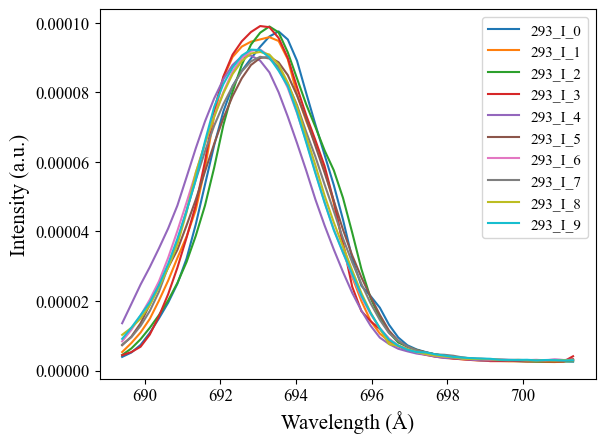

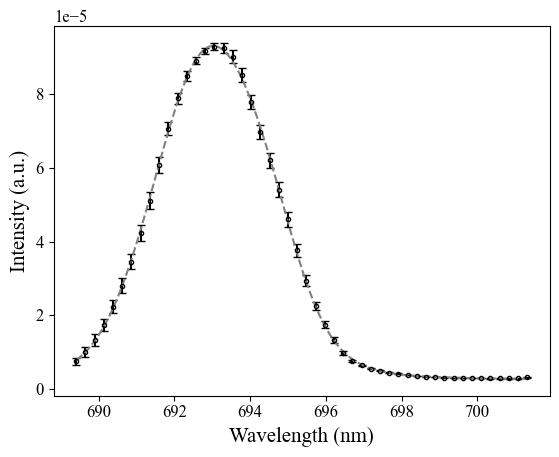

R1 = 694.5344470919382 ± 0.01462563399404467
R2 = 692.8764650225862


In [294]:
df_293_9795 = pd.read_excel(file, sheets[0])

wavelengths_293_9795 = wavelength_extraction(np.arange(0, 50, 1), 9795)
spectrum_293_9795, mean_spectrum_293_9795, err_293_9795 = normalise_spectra(df_293_9795, column_names[0],
                                                                            wavelengths_293_9795)

for i, col in enumerate(column_names[0]):
    plt.figure(1)
    plt.plot(wavelengths_293_9795, spectrum_293_9795[i], label=col)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.show()
p0_293_9795 = [np.max(mean_spectrum_293_9795) / 2, 692.9, 0.3, 0.3, np.max(mean_spectrum_293_9795) / 2, 1.4, 0.3, 0.3,
               np.min(mean_spectrum_293_9795)]

bounds_293_9795 = [
    [0, 692, 0, 0, 0, 0, 0, 0, 0],  #lower
    [np.inf, 696, np.inf, np.inf, np.inf, 3, np.inf, np.inf, np.inf]  #upper
]

pop_293_9795, cov_293_9795 = curve_fit(voigt_model_double,
                                       wavelengths_293_9795,
                                       mean_spectrum_293_9795,
                                       sigma=err_293_9795,
                                       absolute_sigma=True,
                                       p0=p0_293_9795,
                                       bounds=bounds_293_9795)

plt.figure(1)
plt.errorbar(wavelengths_293_9795, mean_spectrum_293_9795, yerr=err_293_9795, capsize=3, fmt='o', linestyle="none",
             markerfacecolor="none", color="black", ms=3)
plt.plot(np.arange(wavelengths_293_9795[-1], wavelengths_293_9795[0], 0.1),
         voigt_model_double(np.arange(wavelengths_293_9795[-1], wavelengths_293_9795[0], 0.1), *pop_293_9795),
         color='grey', linestyle="--")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity (a.u.)")
plt.show()
print(f"R1 = {pop_293_9795[1] + pop_293_9795[5]} ± {np.sqrt(cov_293_9795[1][1] ** 2 + cov_293_9795[5][5] ** 2)}")
print(f"R2 = {pop_293_9795[1]}")

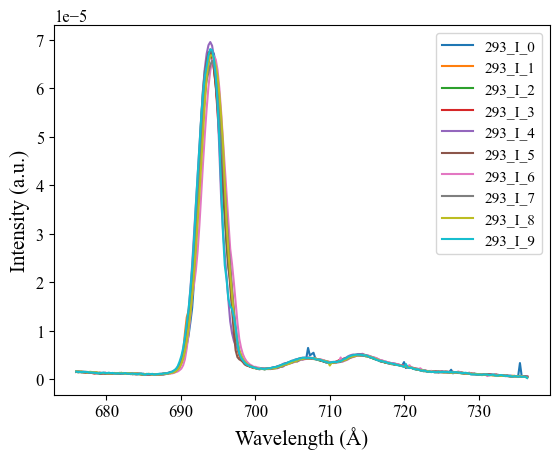

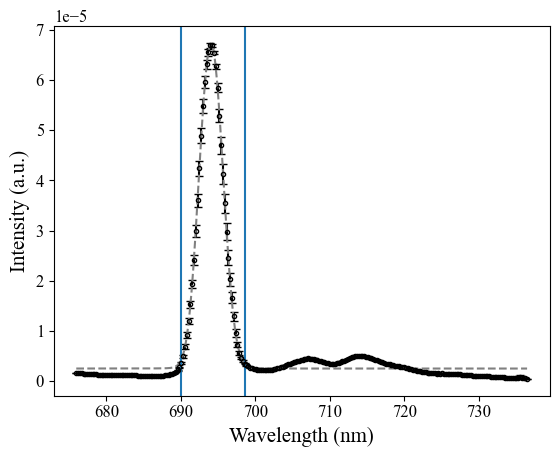

R1 = 694.2898208656322 ± 1.2260315036306042
R2 = 692.7400504962216 ± 1.2151567752937333


In [295]:
df_293_9830 = pd.read_excel(file, sheets[1])

wavelengths_293_9830 = wavelength_extraction(np.arange(0, 250, 1), 9830)

spectrum_293_9830, mean_spectrum_293_9830, err_293_9830 = normalise_spectra(df_293_9830, column_names[1],
                                                                            wavelengths_293_9830)

for i, col in enumerate(column_names[1]):
    plt.figure(1)
    plt.plot(wavelengths_293_9830, spectrum_293_9830[i], label=col)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.show()
p0_293_9830 = [np.max(mean_spectrum_293_9830) / 2, 692.9, 0.3, 0.3, np.max(mean_spectrum_293_9830) / 2, 1.4, 0.3, 0.3,
               np.min(mean_spectrum_293_9830)]

bounds_293_9830 = [
    [0, 692, 0, 0, 0, 0, 0, 0, 0],  #lower
    [np.inf, 696, np.inf, np.inf, np.inf, 3, np.inf, np.inf, np.inf]  #upper
]

##### mask #####
fraction_293 = 0.05  # keep points above 1% of peak

baseline_293 = np.min(mean_spectrum_293_9830)
height_293 = np.max(mean_spectrum_293_9830) - baseline_293
threshold_293 = baseline_293 + fraction_293 * height_293

mask_293 = mean_spectrum_293_9830 > threshold_293

# Find contiguous region around the main peak
peak_index_293 = np.argmax(mean_spectrum_293_9830)

left_293 = peak_index_293
while left_293 > 0 and mask_293[left_293]:
    left_293 -= 1

right_293 = peak_index_293
while right_293 < len(mask_293)-1 and mask_293[right_293]:
    right_293 += 1

fit_mask_293 = np.zeros_like(mask_293, dtype=bool)
fit_mask_293[left_293:right_293] = True
##### ##### #####

pop_293_9830, cov_293_9830 = curve_fit(
    voigt_model_double,
    wavelengths_293_9830[fit_mask_293],
    mean_spectrum_293_9830[fit_mask_293],
    sigma=err_293_9830[fit_mask_293],
    absolute_sigma=True,
    p0=p0_293_9830,
    bounds=bounds_293_9830
)

plt.figure(1)
plt.errorbar(wavelengths_293_9830, mean_spectrum_293_9830, yerr=err_293_9830, capsize=3, fmt='o', linestyle="none",
             markerfacecolor="none", color="black", ms=3)
plt.plot(np.arange(wavelengths_293_9830[-1], wavelengths_293_9830[0], 0.1),
         voigt_model_double(np.arange(wavelengths_293_9830[-1], wavelengths_293_9830[0], 0.1), *pop_293_9830),
         color='grey', linestyle="--")
plt.axvline(wavelengths_293_9830[left_293])
plt.axvline(wavelengths_293_9830[right_293])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity (a.u.)")
plt.show()
print(f"R1 = {pop_293_9830[1] + pop_293_9830[5]} ± {np.sqrt(cov_293_9830[1][1] + cov_293_9830[5][5])}")
print(f"R2 = {pop_293_9830[1]} ± {np.sqrt(cov_293_9830[1][1])}")

# 77K calculations

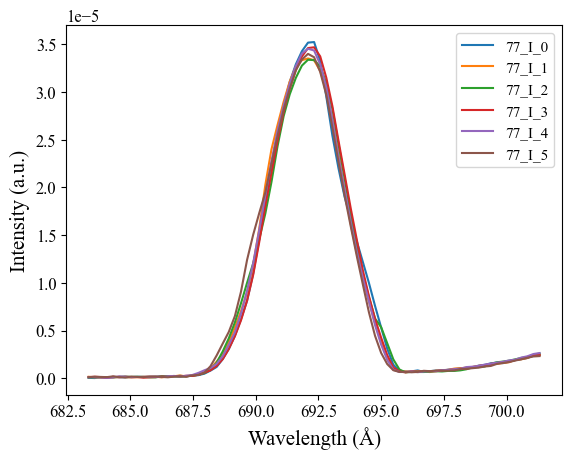

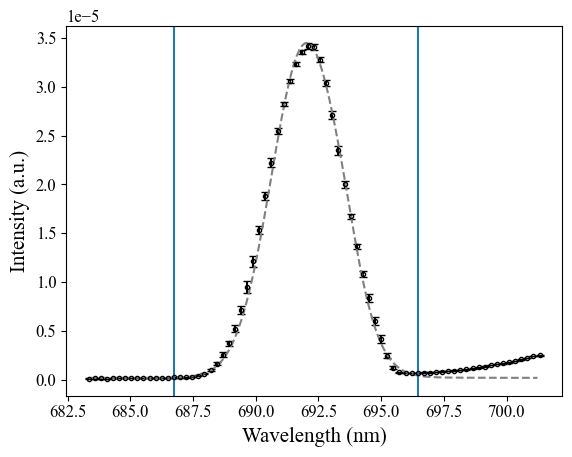

R1 = 693.5287509903778 ± 0.08705266793123695
R2 = 692.0000000000001± 0.027210683209869874
A1 = 4.6772727962204125e-06
A2 = 0.00011731365534387875


In [296]:
df_77_9795 = pd.read_excel(file, sheets[2])

wavelengths_77_9795 = wavelength_extraction(np.arange(0, 75, 1), 9795)
spectrum_77_9795, mean_spectrum_77_9795, err_77_9795 = normalise_spectra(df_77_9795, column_names[2],
                                                                            wavelengths_77_9795)

for i, col in enumerate(column_names[2]):
    plt.figure(1)
    plt.plot(wavelengths_77_9795, spectrum_77_9795[i], label=col)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.show()
p0_77_9795 = [np.max(mean_spectrum_77_9795) / 2, 692.9, 0.3, 0.3, np.max(mean_spectrum_77_9795) / 2, 1.4, 0.3, 0.3,
               np.min(mean_spectrum_77_9795)]

bounds_77_9795 = [
    [0, 692, 0, 0, 0, 0, 0, 0, 0],  #lower
    [np.inf, 694, np.inf, np.inf, np.inf, 3, np.inf, np.inf, np.inf]  #upper
]

padding_77_9795 = [
    20, #upper
    60 #lower
]

pop_77_9795, cov_77_9795 = curve_fit(voigt_model_double,
                                       wavelengths_77_9795[padding_77_9795[0]:padding_77_9795[1]],
                                       mean_spectrum_77_9795[padding_77_9795[0]:padding_77_9795[1]],
                                       sigma=err_77_9795[padding_77_9795[0]:padding_77_9795[1]],
                                       absolute_sigma=True,
                                       p0=p0_77_9795,
                                       bounds=bounds_77_9795)

plt.figure(1)
plt.errorbar(wavelengths_77_9795, mean_spectrum_77_9795, yerr=err_77_9795, capsize=3, fmt='o', linestyle="none",
             markerfacecolor="none", color="black", ms=3)
plt.plot(np.arange(wavelengths_77_9795[-1], wavelengths_77_9795[0], 0.1),
         voigt_model_double(np.arange(wavelengths_77_9795[-1], wavelengths_77_9795[0], 0.1), *pop_77_9795),
         color='grey', linestyle="--")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity (a.u.)")

plt.axvline(wavelengths_77_9795[padding_77_9795[0]])
plt.axvline(wavelengths_77_9795[padding_77_9795[1]])
plt.show()
print(f"R1 = {pop_77_9795[1] + pop_77_9795[5]} ± {np.sqrt(cov_77_9795[1][1]+ cov_77_9795[5][5])}")
print(f"R2 = {pop_77_9795[1]}± {np.sqrt(cov_77_9795[1][1])}")

print(f"A1 = {pop_77_9795[4]}")
print(f"A2 = {pop_77_9795[0]}")

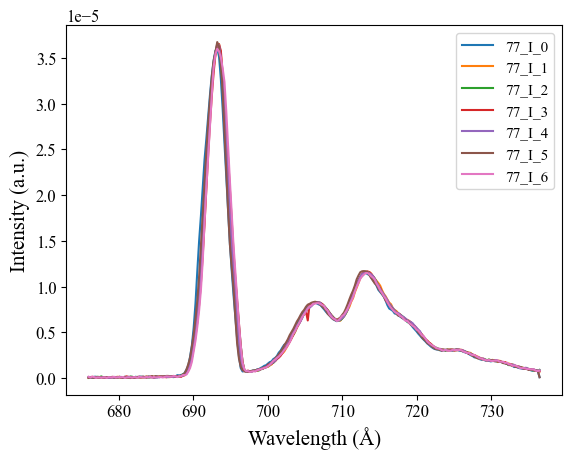

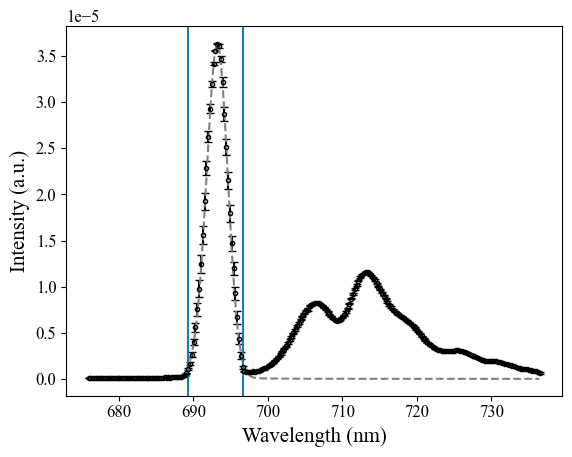

R1 = 693.4001186360405 ± 37604.363959063194
R2 = 692.4299761813845 ± 172.46085451180255


In [297]:
df_77_9830 = pd.read_excel(file, sheets[3])

wavelengths_77_9830 = wavelength_extraction(np.arange(0, 250, 1), 9830)

spectrum_77_9830, mean_spectrum_77_9830, err_77_9830 = normalise_spectra(df_77_9830, column_names[3],
                                                                            wavelengths_77_9830)

for i, col in enumerate(column_names[3]):
    plt.figure(1)
    plt.plot(wavelengths_77_9830, spectrum_77_9830[i], label=col)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.show()
p0_77_9830 = [np.max(mean_spectrum_77_9830) / 2, 694.3, 0.3, 0.3, np.max(mean_spectrum_77_9830) / 2, 1.4, 0.3, 0.3,
               np.min(mean_spectrum_77_9830)]

bounds_77_9830 = [
    [0, 692, 0, 0, 0, 0, 0, 0, 0],  #lower
    [np.inf, 696, np.inf, np.inf, np.inf, 3, np.inf, np.inf, np.inf]  #upper
]

##### mask #####
fraction_77 = 0.04  # keep points above 1% of peak

baseline_77 = np.min(mean_spectrum_77_9830)
height_77 = np.max(mean_spectrum_77_9830) - baseline_77
threshold_77 = baseline_77 + fraction_77 * height_77

mask_77 = mean_spectrum_77_9830 > threshold_77

# Find contiguous region around the main peak
peak_index_77 = np.argmax(mean_spectrum_77_9830)

left_77 = peak_index_77
while left_77 > 0 and mask_77[left_77]:
    left_77 -= 1

right_77 = peak_index_77
while right_77 < len(mask_77)-1 and mask_77[right_77]:
    right_77 += 1

fit_mask_77 = np.zeros_like(mask_77, dtype=bool)
fit_mask_77[left_77:right_77] = True
##### ##### #####

pop_77_9830, cov_77_9830 = curve_fit(
    voigt_model_double,
    wavelengths_77_9830[fit_mask_77],
    mean_spectrum_77_9830[fit_mask_77],
    sigma=err_77_9830[fit_mask_77],
    absolute_sigma=True,
    p0=p0_77_9830,
    bounds=bounds_77_9830
)

plt.figure(1)
plt.errorbar(wavelengths_77_9830, mean_spectrum_77_9830, yerr=err_77_9830, capsize=3, fmt='o', linestyle="none",
             markerfacecolor="none", color="black", ms=3)
plt.plot(np.arange(wavelengths_77_9830[-1], wavelengths_77_9830[0], 0.1),
         voigt_model_double(np.arange(wavelengths_77_9830[-1], wavelengths_77_9830[0], 0.1), *pop_77_9830),
         color='grey', linestyle="--")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity (a.u.)")

plt.axvline(wavelengths_293_9830[left_77])
plt.axvline(wavelengths_293_9830[right_77])
plt.show()
print(f"R1 = {pop_77_9830[1] + pop_77_9830[5]} ± {np.sqrt(cov_77_9830[1][1] ** 2 + cov_77_9830[5][5] ** 2)}")
print(f"R2 = {pop_77_9830[1]} ± {np.sqrt(cov_77_9830[1][1])}")

# Main Plot try 1

In [298]:
residuals_293 = (mean_spectrum_293_9830[left_293:right_293] - voigt_model_double(wavelengths_293_9830[left_293:right_293], *pop_293_9830))/ err_293_9830[left_293:right_293]
residuals_77 = (mean_spectrum_77_9830[left_77:right_77] - voigt_model_double(wavelengths_77_9830[left_77:right_77], *pop_77_9830))/ err_77_9830[left_77:right_77]

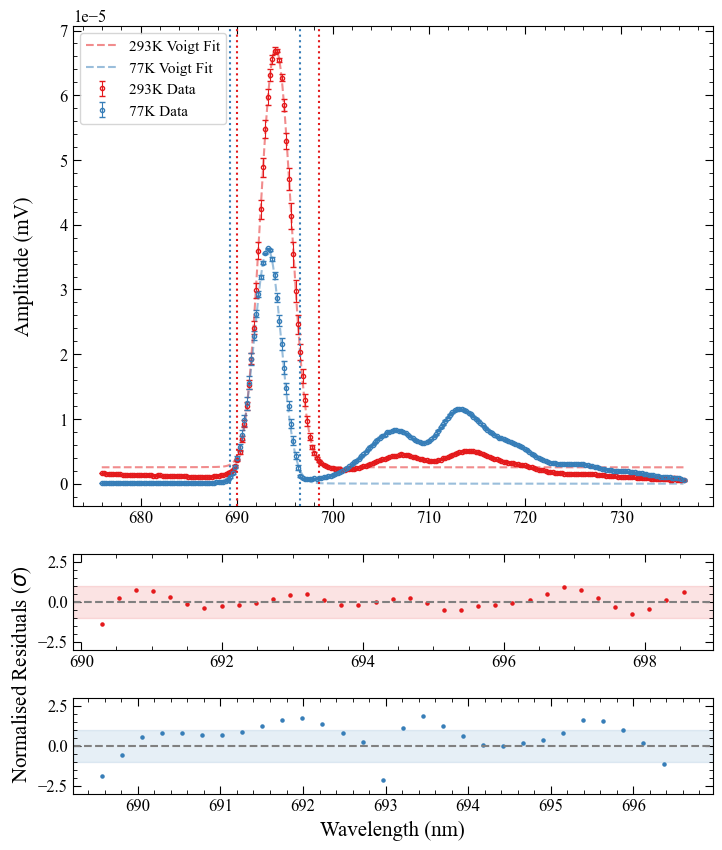

In [299]:
red_cb = "#e41a1c"
blue_cb = "#377eb8"
CI_293 = 1.96/np.sqrt(len(residuals_293))
CI_77 = 1.96/np.sqrt(len(residuals_77))

fig = plt.figure(1)

wavelength_range = np.arange(wavelengths_293_9830[-1], wavelengths_293_9830[0], 0.1)

ax_main = fig.add_axes([0,0,1,1])

ax_main.errorbar(wavelengths_293_9830, mean_spectrum_293_9830, yerr= err_293_9830,color= red_cb, capsize = 2, fmt='o', linestyle="none", markerfacecolor="none", markersize = 3, elinewidth = 0.8, label = "293K Data")
ax_main.errorbar(wavelengths_77_9830, mean_spectrum_77_9830, yerr= err_77_9830, color= blue_cb, capsize = 2, fmt='o', linestyle="none", markerfacecolor="none", markersize = 3, elinewidth = 0.8, label = "77K Data")

ax_main.plot(wavelength_range, voigt_model_double(wavelength_range, *pop_293_9830), color =  red_cb, linestyle="--", alpha = 0.5, label = "293K Voigt Fit")
ax_main.plot(wavelength_range, voigt_model_double(wavelength_range, *pop_77_9830), color = blue_cb, linestyle="--", alpha = 0.5, label = "77K Voigt Fit")


ax_main.set_ylabel("Amplitude (mV)")
ax_main.yaxis.set_label_coords(-0.06, 0.5)

ax_main.legend(loc = "upper left")
ax_main.minorticks_on()
ax_main.tick_params(which='major', size= 6, direction='in',
                right = True, top = True, left = True, bottom = True)
ax_main.tick_params(which='minor', size= 3, direction='in',
                right = True, top = True, left = True, bottom = True)

#plot the mask
ax_main.axvline(wavelengths_293_9830[left_293], color = red_cb, linestyle=":")
ax_main.axvline(wavelengths_293_9830[right_293], color = red_cb, linestyle=":")
ax_main.axvline(wavelengths_77_9830[left_77], color = blue_cb, linestyle=":")
ax_main.axvline(wavelengths_77_9830[right_77], color = blue_cb, linestyle=":")


ax_res1 = fig.add_axes([0,-0.3,1,0.2])

ax_res1.scatter(wavelengths_293_9830[left_293:right_293], residuals_293, color= red_cb, marker='o', s=5)

ax_res1.minorticks_on()
ax_res1.tick_params(which='major', size= 6, direction='in',
                right = True, top = True, left = True, bottom = True)
ax_res1.tick_params(which='minor', size= 3, direction='in',
                right = True, top = True, left = True, bottom = True)

ax_res1.axhspan(-1, 1, color = red_cb, alpha = 0.12)
ax_res1.axhline(0, color = "grey", linewidth = 1.5, linestyle = "--")
ax_res1.set_ylim(-3,3)



ax_res2 = fig.add_axes([0,-0.6,1,0.2])

ax_res2.scatter(wavelengths_77_9830[left_77:right_77], residuals_77, color= blue_cb, marker='o', s=5)

ax_res2.set_xlabel("Wavelength (nm)")
ax_res2.set_ylabel(rf"Normalised Residuals ($\sigma$)")
ax_res2.yaxis.set_label_coords(-0.06, 1.25)
ax_res2.minorticks_on()
ax_res2.tick_params(which='major', size= 6, direction='in',
                right = True, top = True, left = True, bottom = True)
ax_res2.tick_params(which='minor', size= 3, direction='in',
                right = True, top = True, left = True, bottom = True)
ax_res2.axhspan(-1, 1, color = blue_cb, alpha = 0.12)
ax_res2.axhline(0, color = "grey", linewidth = 1.5, linestyle = "--")
ax_res2.set_ylim(-3,3)
plt.show()

# Main plot try 2

In [302]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

red_cb = "#e41a1c"
blue_cb = "#377eb8"

# R1 and R2 positions
R1_293 = pop_293_9830[1] + pop_293_9830[5]
R2_293 = pop_293_9830[1]

# R1 and R2 amplitudes
amp_R1_293 = voigt_model_double(np.array([R1_293]), *pop_293_9830)[0]
amp_R2_293 = voigt_model_double(np.array([R2_293]), *pop_293_9830)[0]

R1_77 = pop_77_9830[1] + pop_77_9830[5]
R2_77 = pop_77_9830[1]

amp_R1_77 = voigt_model_double(np.array([R1_77]), *pop_77_9830)[0]
amp_R2_77 = voigt_model_double(np.array([R2_77]), *pop_77_9830)[0]

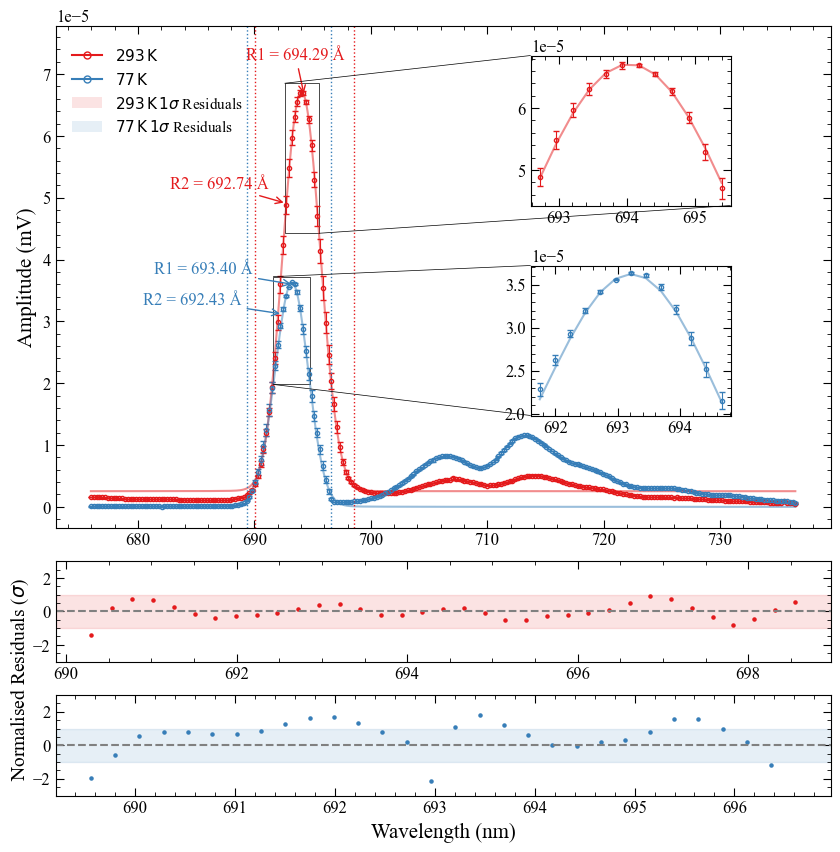

In [341]:
fig = plt.figure(figsize=(10,10))

# Add extra spacing and larger residual panels
gs = fig.add_gridspec(
    5, 1,
    height_ratios=[6, 0.4, 1.2, 0.4, 1.2],  # spacer rows included
    hspace=0.0
)

ax_main = fig.add_subplot(gs[0])
ax_res1 = fig.add_subplot(gs[2])
ax_res2 = fig.add_subplot(gs[4])

wavelength_range = np.arange(
    wavelengths_293_9830[-1],
    wavelengths_293_9830[0],
    0.1
)

# =====================
# Main spectrum
# =====================
data293 = ax_main.errorbar(
    wavelengths_293_9830, mean_spectrum_293_9830, yerr=err_293_9830,
    color=red_cb, capsize=2, fmt='o', linestyle="none",
    markerfacecolor="none", markersize=3, elinewidth=0.8,
    label=r"$293\,\mathrm{K}$ Data"
)

data77 = ax_main.errorbar(
    wavelengths_77_9830, mean_spectrum_77_9830, yerr=err_77_9830,
    color=blue_cb, capsize=2, fmt='o', linestyle="none",
    markerfacecolor="none", markersize=3, elinewidth=0.8,
    label=r"$77\,\mathrm{K}$ Data"
)

fit293, = ax_main.plot(
    wavelength_range,
    voigt_model_double(wavelength_range, *pop_293_9830),
    color=red_cb, linestyle="-", alpha=0.5,
    label=r"$293\,\mathrm{K}$ Voigt Fit"
)

fit77, =ax_main.plot(
    wavelength_range,
    voigt_model_double(wavelength_range, *pop_77_9830),
    color=blue_cb, linestyle="-", alpha=0.5,
    label=r"$77\,\mathrm{K}$ Voigt Fit"
)

# Get current limits
ymin, ymax = ax_main.get_ylim()

# Extend the top by, say, 10%
ax_main.set_ylim(ymin, ymax*1.1)

# Mask boundaries
ax_main.axvline(wavelengths_293_9830[left_293], color=red_cb, linestyle=":",linewidth=1, label = "293K Mask")
ax_main.axvline(wavelengths_293_9830[right_293], color=red_cb, linestyle=":",linewidth=1)
ax_main.axvline(wavelengths_77_9830[left_77], color=blue_cb, linestyle=":",linewidth=1, label = "77K Mask")
ax_main.axvline(wavelengths_77_9830[right_77], color=blue_cb, linestyle=":",linewidth=1)

ax_main.set_ylabel("Amplitude (mV)")

residual_band_293 = Patch(
    facecolor=red_cb,
    alpha=0.12,
    label=r"$293\,\mathrm{K}\, 1\sigma$ Residuals"
)

residual_band_77 = Patch(
    facecolor=blue_cb,
    alpha=0.12,
    label=r"$77\,\mathrm{K}\, 1\sigma$ Residuals"
)

legend_elements = [
    Line2D([0], [0],
           color=red_cb,
           marker='o',
           linestyle='-',
           markerfacecolor="none", markersize=5, linewidth=1.5,

           label=r"$293\,\mathrm{K}$"),

    Line2D([0], [0],
           color=blue_cb,
           marker='o',
           linestyle='-',
           markerfacecolor="none", markersize=5, linewidth=1.5,
           label=r"$77\,\mathrm{K}$"),
    residual_band_293,
    residual_band_77
]

ax_main.legend(
    handles = legend_elements,
    loc = "upper left",
    bbox_to_anchor = (0.005, 0.98),
    borderpad = 0.3,
    frameon = False
)

# Annotate on ax_main
ax_main.annotate(
    rf"R1 = {R1_293:.2f} Å",
    xy=(R1_293, amp_R1_293),
    xytext=(R1_293-5, amp_R1_293*1.09),
    arrowprops=dict(arrowstyle="->", color=red_cb, lw=1),
    color=red_cb,
    fontsize=12
)

ax_main.annotate(
    rf"R2 = {R2_293:.2f} Å",
    xy=(R2_293, amp_R2_293),
    xytext=(R2_293-10, amp_R2_293*1.05),
    arrowprops=dict(arrowstyle="->", color=red_cb, lw=1),
    color=red_cb,
    fontsize=12
)

ax_main.annotate(
    rf"R1 = {R1_77:.2f} Å",
    xy=(R1_77, amp_R1_77),
    xytext=(R1_77-12, amp_R1_77*1.05),
    arrowprops=dict(arrowstyle="->", color=blue_cb, lw=1),
    color=blue_cb,
    fontsize=12
)

ax_main.annotate(
    rf"R2 = {R2_77:.2f} Å",
    xy=(R2_77, amp_R2_77),
    xytext=(R2_77-12, amp_R2_77*1.05),
    arrowprops=dict(arrowstyle="->", color=blue_cb, lw=1),
    color=blue_cb,
    fontsize=12
)

# =====================
# Residuals 293K
# =====================
ax_res1.scatter(
    wavelengths_293_9830[left_293:right_293],
    residuals_293,
    color=red_cb, s=5
)

ax_res1.axhspan(-1, 1, color=red_cb, alpha=0.12)
ax_res1.axhline(0, color="grey", linestyle="--")
ax_res1.set_ylim(-3, 3)

# =====================
# Residuals 77K
# =====================
ax_res2.scatter(
    wavelengths_77_9830[left_77:right_77],
    residuals_77,
    color=blue_cb, s=5
)

ax_res2.axhspan(-1, 1, color=blue_cb, alpha=0.12)
ax_res2.axhline(0, color="grey", linestyle="--")
ax_res2.set_ylim(-3, 3)

ax_res2.set_xlabel("Wavelength (nm)")


# Get positions of residual axes
pos1 = ax_res1.get_position()
pos2 = ax_res2.get_position()

# Midpoint of the gap between them
y_mid = (pos1.y0 + pos2.y1) / 2

# Shared residual label
fig.text(
    0.09, y_mid,
    r"Normalised Residuals ($\sigma$)",
    rotation=90,
    va='center',
    ha='center'
)

inset_293 = fig.add_axes([0.6,0.7,0.2,0.15])
mark_inset(ax_main, inset_293, loc1=2, loc2=4, fc="none", ec="black", lw = 0.5)
inset_293.errorbar(wavelengths_293_9830[left_293+13:right_293-10],mean_spectrum_293_9830[left_293+13:right_293-10], yerr = err_293_9830[left_293+13:right_293-10],
                   color=red_cb, capsize=2, fmt='o', linestyle="none", markerfacecolor="none", markersize=3, elinewidth=0.8)
inset_293.plot(wavelengths_293_9830[left_293+13:right_293-10],voigt_model_double(wavelengths_293_9830[left_293+13:right_293-10],*pop_293_9830),
               color=red_cb, linestyle="-", alpha=0.5)

inset_77 = fig.add_axes([0.6,0.49,0.2,0.15])

c, d = 16, 6
mark_inset(ax_main, inset_77, loc1=2, loc2=3, fc="none", ec="black", lw = 0.5)
inset_77.errorbar(wavelengths_77_9830[left_293+c:right_293-d],mean_spectrum_77_9830[left_293+c:right_293-d], yerr = err_77_9830[left_293+c:right_293-d],
                   color=blue_cb, capsize=2, fmt='o', linestyle="none", markerfacecolor="none", markersize=3, elinewidth=0.8)
inset_77.plot(wavelengths_77_9830[left_293+c:right_293-d],voigt_model_double(wavelengths_77_9830[left_293+c:right_293-d],*pop_77_9830),
               color=blue_cb, linestyle="-", alpha=0.5)


# Styling
for ax in [ax_main, ax_res1, ax_res2,inset_293,inset_77]:
    ax.minorticks_on()
    ax.tick_params(which='major', size=6, direction='in',
                   right=True, top=True)
    ax.tick_params(which='minor', size=3, direction='in',
                   right=True, top=True)

plt.show()